<a href="https://colab.research.google.com/github/ItaloNardy/NetworkAnalysis_U3/blob/main/ProjU3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
!pip install pyvis python-louvain networkx pandas matplotlib seaborn

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from pyvis.network import Network
from IPython.display import display, HTML
import tempfile
import os

# Try Louvain and Pyvis
try:
    import community as community_louvain
except ImportError:
    !pip install python-louvain
    import community as community_louvain

try:
    from pyvis.network import Network
except ImportError:
    !pip install pyvis
    from pyvis.network import Network

In [2]:
# Load dataset
url = "https://raw.githubusercontent.com/ItaloNardy/NetworkAnalysis_U3/refs/heads/main/marvel-unimodal-edges.csv"
df = pd.read_csv(url)

# Ensure required columns
if not {'Source', 'Target', 'Weight'}.issubset(df.columns):
    raise ValueError("CSV must contain 'Source', 'Target', and 'Weight' columns.")

# Edge limit input
default_limit = 9891
edge_limit = input(f"Enter number of edges to display (default={default_limit}): ").strip()
if not edge_limit.isdigit():
    edge_limit = default_limit
else:
    edge_limit = int(edge_limit)

df = df.head(edge_limit)
print(f"Displaying first {edge_limit} edges.")


Enter number of edges to display (default=9891): 9891
Displaying first 9891 edges.


In [3]:
# Build NetworkX graph
G = nx.from_pandas_edgelist(df, source='Source', target='Target', edge_attr='Weight')
partition = community_louvain.best_partition(G)
degree_dict = dict(G.degree())
max_degree = max(degree_dict.values()) if degree_dict else 1

# Color palette
palette = [
    "#e6194b", "#3cb44b", "#ffe119", "#4363d8", "#f58231",
    "#911eb4", "#46f0f0", "#f032e6", "#bcf60c", "#fabebe",
    "#008080", "#e6beff", "#9a6324", "#fffac8", "#800000"
]


In [4]:
# Pyvis network
net = Network(height='900px', width='100%', notebook=True, cdn_resources='in_line')

for node in G.nodes():
    community_id = partition.get(node, 0)
    degree = degree_dict.get(node, 1)
    size = 15 + (degree / max_degree) * 35
    color = palette[community_id % len(palette)]

    net.add_node(
        node,
        label=node,
        title=f"Community: {community_id}\nDegree: {degree}",
        color=color,
        size=size,
        shape="dot"
    )

for _, row in df.iterrows():
    net.add_edge(row['Source'], row['Target'], value=row['Weight'])

net.show_buttons(filter_=['physics'])


In [5]:
# Save and display interactive network in notebook
with tempfile.NamedTemporaryFile(delete=False, suffix=".html") as tmp_file:
    path = tmp_file.name
    net.save_graph(path)

display(HTML(filename=path))


In [6]:
# Network Analysis
if nx.is_connected(G):
    G_connected = G
else:
    largest_cc = max(nx.connected_components(G), key=len)
    G_connected = G.subgraph(largest_cc).copy()
    print("Graph not connected. Using largest connected component.")

# Adjacency matrix
adj_matrix = nx.adjacency_matrix(G_connected)
adj_df = pd.DataFrame(adj_matrix.todense(), index=G_connected.nodes(), columns=G_connected.nodes())
display(adj_df)


,Black Panther / T'chal,Loki [asgardian],Mantis / ? Brandt,Iceman / Robert Bobby,Marvel Girl / Jean Grey,Cyclops / Scott Summer,Klaw / Ulysses Klaw,Human Torch / Johnny S,"Richards, Franklin B",Wolverine / Logan,...,Asp Ii / Cleo,Black Mamba / Tanya Se,Meggan,"Austin, Susan",Diamondback Ii / Rache,Makkari / Mike Khary / I,"Hodge, Cameron",Skin / Angelo Espinosa,Husk / Paige Guthrie,Deadpool / Jack / Wade W
Black Panther / T'chal,0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
Loki [asgardian],1,0,1,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
Mantis / ? Brandt,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Iceman / Robert Bobby,1,0,0,0,1,1,0,1,1,1,...,0,0,0,0,0,0,1,0,0,0
Marvel Girl / Jean Grey,1,0,0,1,0,1,0,1,1,1,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Makkari / Mike Khary / I,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
"Hodge, Cameron",0,0,0,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
Skin / Angelo Espinosa,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
Husk / Paige Guthrie,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [7]:
# Diameter
diameter = nx.diameter(G_connected)
print(f"Network Diameter: {diameter}")

# Periphery
periphery_nodes = list(nx.periphery(G_connected))
print(f"Periphery Nodes ({len(periphery_nodes)}):")
print(periphery_nodes)

# Density
density = nx.density(G_connected)
print(f"Density: {density:.5f}, Sparsity: {(1 - density):.5f}")

# Assortativity
try:
    assortativity = nx.degree_assortativity_coefficient(G_connected)
    print(f"Degree Assortativity Coefficient: {assortativity:.5f}")
except nx.NetworkXError as e:
    print(f"Assortativity error: {e}")

Network Diameter: 3
Periphery Nodes (252):
['Loki [asgardian]', 'Mantis / ? Brandt', 'Klaw / Ulysses Klaw', 'Firebird / Bonita Juar', 'Medusa / Medusalith Am', 'Jack Of Hearts / Jack', 'Mephisto', 'Swordsman / Jacques Du', 'Collector / Taneleer T', 'Lockjaw [inhuman]', 'Pharaoh Rama-tut', 'Ant-man Ii / Scott Har', 'Lyja Lazerfist [skru', 'Gorgon [inhuman]', 'Nighthawk Ii / Kyle Ri', 'Cage, Luke / Carl Luca', 'Hellcat / Patsy Walker', 'Karnak [inhuman]', 'Redwing', 'Daredevil / Matt Murdo', 'Norriss, Sister Barb', 'Rage / Elvin Daryl Hal', 'Demolition Man / Denni', 'Sersi / Sylvia', 'Gyrich, Henry Peter', 'Ghaur [deviant]', 'Carter, Sharon', 'Black Knight V / Dane', 'Sunfire / Shiro Yoshid', 'Triton', 'Ultron', 'Jones, Richard Milho', 'Nelson, Franklin Fog', 'Jarvis, Edwin', 'Jameson, J. Jonah', 'Masters, Alicia Reis', 'Iron Fist / Daniel Ran', 'Black Bolt / Blackanto', 'Sandman / William Bake', 'Falcon / Sam Wilson', 'Stingray / Dr. Walter', 'Justice Ii / Vance Ast', 'Usagent / Captain

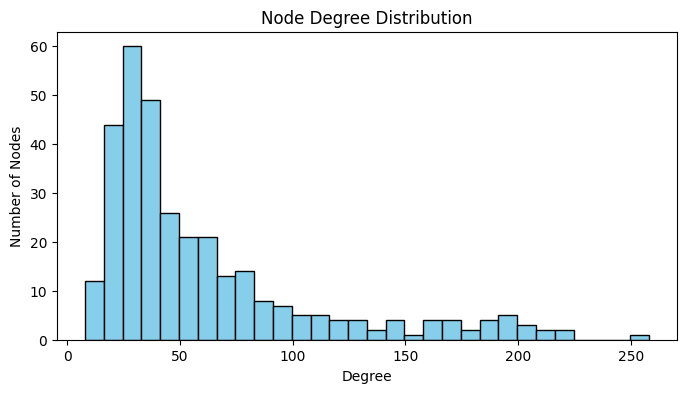

In [8]:
# Degree histogram
degrees = [deg for _, deg in G_connected.degree()]
plt.figure(figsize=(8,4))
plt.hist(degrees, bins=30, color='skyblue', edgecolor='black')
plt.title("Node Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.show()


In [9]:
# Centrality measures
eigen = nx.eigenvector_centrality(G_connected, max_iter=1000)
degree = nx.degree_centrality(G_connected)
closeness = nx.closeness_centrality(G_connected)
betweenness = nx.betweenness_centrality(G_connected)

centrality_df = pd.DataFrame({
    'Node': list(G_connected.nodes()),
    'Eigenvector': [eigen[n] for n in G_connected.nodes()],
    'Degree': [degree[n] for n in G_connected.nodes()],
    'Closeness': [closeness[n] for n in G_connected.nodes()],
    'Betweenness': [betweenness[n] for n in G_connected.nodes()]
})

# Display top 10 nodes per metric in descending order
top_k = 10

for metric in ['Eigenvector', 'Degree', 'Closeness', 'Betweenness']:
    print(f"\nTop {top_k} nodes by {metric} centrality:")
    print(centrality_df[['Node', metric]].sort_values(by=metric, ascending=False).head(top_k).reset_index(drop=True))



Top 10 nodes by Eigenvector centrality:
                        Node  Eigenvector
0            Captain America     0.139418
1          Wolverine / Logan     0.131218
2     Thing / Benjamin J. Gr     0.129755
3                     Vision     0.127247
4     Beast / Henry &hank& P     0.126039
5  Spider-man / Peter Parker     0.123751
6     Human Torch / Johnny S     0.123180
7      Invisible Woman / Sue     0.123150
8     Cyclops / Scott Summer     0.123089
9      Scarlet Witch / Wanda     0.122284

Top 10 nodes by Degree centrality:
                        Node    Degree
0            Captain America  0.791411
1          Wolverine / Logan  0.674847
2  Spider-man / Peter Parker  0.668712
3     Thing / Benjamin J. Gr  0.656442
4                     Vision  0.653374
5     Beast / Henry &hank& P  0.628834
6     Thor / Dr. Donald Blak  0.628834
7      Iron Man / Tony Stark  0.622699
8     Mr. Fantastic / Reed R  0.607362
9     Cyclops / Scott Summer  0.604294

Top 10 nodes by Closeness centr

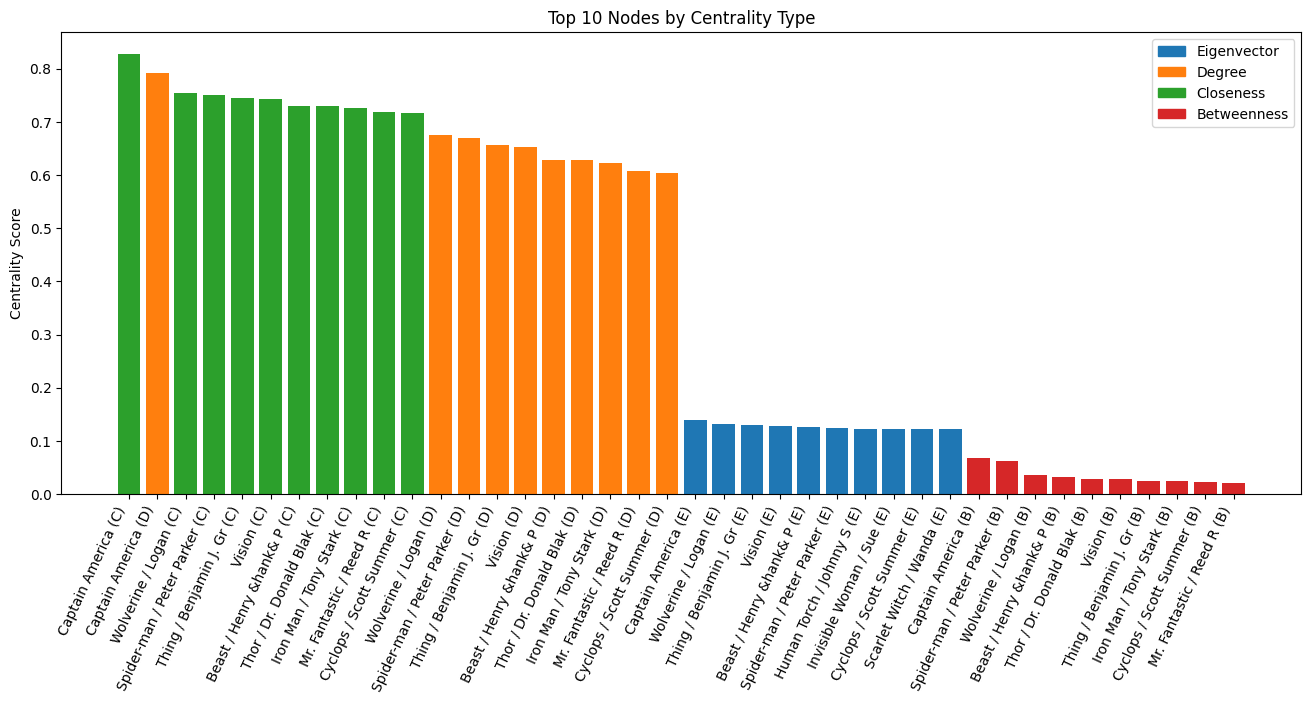

In [10]:
# Plot Top 10 per centrality
top_k = 10
label_map = {'Eigenvector': 'E', 'Degree': 'D', 'Closeness': 'C', 'Betweenness': 'B'}
color_map = {
    'Eigenvector': '#1f77b4',
    'Degree': '#ff7f0e',
    'Closeness': '#2ca02c',
    'Betweenness': '#d62728'
}

melted = centrality_df.melt(id_vars='Node', var_name='Type', value_name='Score')
top_nodes = pd.concat([melted[melted['Type'] == t].nlargest(top_k, 'Score') for t in label_map])
top_nodes = top_nodes.sort_values("Score", ascending=False)

labels = [f"{row['Node']} ({label_map[row['Type']]})" for _, row in top_nodes.iterrows()]
scores = top_nodes['Score'].tolist()
colors = [color_map[row['Type']] for _, row in top_nodes.iterrows()]

plt.figure(figsize=(16, 6))
plt.bar(labels, scores, color=colors)
plt.xticks(rotation=65, ha='right')
plt.ylabel("Centrality Score")
plt.title("Top 10 Nodes by Centrality Type")
handles = [plt.Rectangle((0,0),1,1,color=color_map[t], label=t) for t in color_map]
plt.legend(handles=handles)
plt.show()
